<a href="https://colab.research.google.com/github/fifeo/CS466-Bioinformatics/blob/main/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NOTE

- Make a copy of this template before you start editing, and exported the file as a ipynb where you are done.

- Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Runtime$\rightarrow$Factory reset runtime) and then **run all cells** (in the menubar, select Runtime$\rightarrow$Run all).

- Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE". Fill out your name below in the `NAME` variable, leave the `COLLABORATORS` variable empty.

In [ ]:
NAME = ""
COLLABORATORS = ""

---

# Homework 4

## Copy number callers



In this homework assignment we will develop a copy number caller based on a Hidden Markov Model. In addition, we will implement a hierarchical clustering algorithm. The data that we consider is from a previously published [breast tumor](http://dx.doi.org/10.1038/nature09807), from which 100 single cells have been sequenced. In this homework assignment we restrict our attention to a subset of 25 cells.

_Instructions:_ There are four questions, worth a total of 100 points. In addition, there are two bonus questions (Q2e and Q4c), each worth 5 points. Insert your answer after each question in the designated box. Replace comments with code.


In [3]:
# Install library and download data

! pip install nose
! pip install numpy
! pip install pandas
! pip install matplotlib

! wget -c 'https://drive.google.com/uc?export=download&id=12pgHOpJ8sRzF_rcnGE-xjAx3Eacu5W97' -O data.zip
! unzip -o data.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 3.2 MB/s eta 0:00:00
--2024-11-23 17:57:13--  https://drive.google.com/uc?export=download&id=12pgHOpJ8sRzF_rcnGE-xjAx3Eacu5W97
Resolving drive.google.com (drive.google.com)... 142.250.152.138, 142.250.152.113, 142.250.152.102, ...
Connecting to drive.google.com (drive.google.com)|142.250.152.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=12pgHOpJ8sRzF_rcnGE-xjAx3Eacu5W97&export=download [following]
--2024-11-23 17:57:13--  https://drive.usercontent.google.com/download?id=12pgHOpJ8sRzF_rcnGE-xjAx3Eacu5W97&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.214.132, 2607:f8b0:4001:c05::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.214.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 896061 (875K) [application/octet-stream]
Saving t

In [5]:
import copy
import sys

import nose.tools as nt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.special import logsumexp
from scipy.stats import norm
from scipy.cluster import hierarchy

## Question 1: Data preparation [20 points]

We start by parsing the data from `data.tsv` using pandas.

In [6]:
df = pd.read_csv("data.tsv", sep="\t", index_col=0)
df.head()

,CHR,START,END,SRR089377,SRR054598,SRR053605,SRR054594,SRR089397,SRR054614,SRR089402,...,SRR054606,SRR054613,SRR053631,SRR054575,SRR053679,SRR054604,SRR053611,SRR053607,SRR053602,SRR054610
bin,,,,,,,,,,,,,,,,,,,,,
0,chr1,1,1246396,2116,298,573,157,3146,1495,4071,...,854,1583,1106,1847,795,562,1211,636,751,1520
1,chr1,1246395,1833664,1940,264,660,204,1643,1207,3809,...,651,848,1252,2024,830,584,836,475,673,1185
2,chr1,1833663,2345598,1767,261,870,237,1655,1621,5418,...,707,1372,1342,2531,1153,874,936,630,818,1366
3,chr1,2345597,2946628,2246,446,854,265,1564,1838,5625,...,1227,1172,1578,2909,1373,884,1184,604,973,1701
4,chr1,2946627,3452945,2189,363,883,217,2081,1173,4845,...,687,1371,1562,3235,1053,854,785,649,784,1212


This dataset consists of the following 25 cells:

In [7]:
cells = list(df.columns[3:])
sys.stdout.write("Cells:")
for idx, cell in enumerate(cells):
    if idx % 5 == 0:
        sys.stdout.write("\n")
    sys.stdout.write(cell + " ")

Cells:
SRR089377 SRR054598 SRR053605 SRR054594 SRR089397 
SRR054614 SRR089402 SRR053676 SRR053633 SRR053617 
SRR054608 SRR053608 SRR054602 SRR089401 SRR053668 
SRR054606 SRR054613 SRR053631 SRR054575 SRR053679 
SRR054604 SRR053611 SRR053607 SRR053602 SRR054610 

The reads of each cell are put in bins. As seen in the command below, there are 5363 bins.

In [8]:
len(df.index)

5363

We plot a histogram of the bin sizes as follows, from which we can see that most of the bins have length 500,000.

(400000.0, 1000000.0)

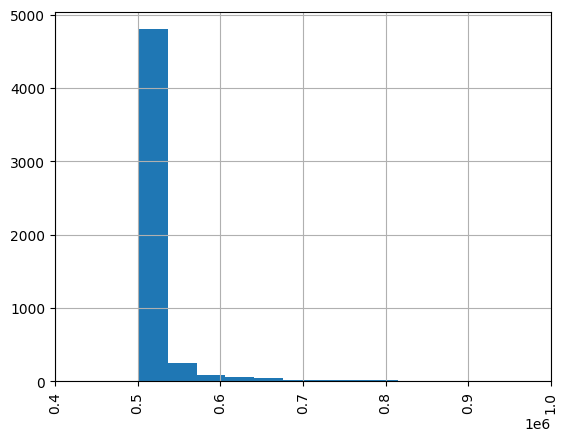

In [9]:
(df['END'] - df['START'] + 1).hist(bins=1000, xrot=90)
plt.xlim((400000, 1000000))

### _Q1a:_ What is the minimum, median and maximum bin size? [4 points]

Set the values of `minimum`, `median`, and `maximum` according to the minimum, median and maximum bin size.

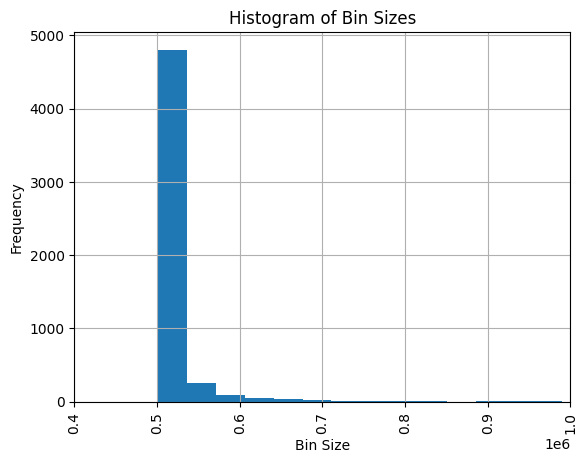

In [10]:
bin_sizes = df['END'] - df['START'] + 1
minimum = bin_sizes.min()
median = bin_sizes.median()
maximum = bin_sizes.max()

# YOUR CODE HERE
bin_sizes.hist(bins=1000, xrot=90)
plt.xlim((400000, 1000000))
plt.title("Histogram of Bin Sizes")
plt.xlabel("Bin Size")
plt.ylabel("Frequency")
plt.show()

We retain bins with lengths between 450,000 and 500,000 using the following command.

In [11]:
df = df[(450000 <= (df['END'] - df['START'] + 1)) & ((df['END'] - df['START'] + 1) <= 550000)]

### _Q1b:_ The column `CHR` contains the chromosome label. Do these cells originate from a male or female patient? [4 points]

Write code here to print unique list of values in `'CHR'` column, this should give you the information you need.

Set the value of `is_female` to `True` or `False` based on the answer to this question.

In [15]:
unique_chr = df['CHR'].unique()
print("Unique Chromosome Labels:", unique_chr)
# YOUR CODE HERE
is_female = 'Y' not in unique_chr

print(f"Do these cells originate from a female patient? {is_female}")

Unique Chromosome Labels: ['chr1' 'chr2' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7' 'chr8' 'chr9' 'chr10'
 'chr11' 'chr12' 'chr13' 'chr14' 'chr15' 'chr16' 'chr17' 'chr18' 'chr19'
 'chr20' 'chr21' 'chr22' 'chrX' 'chrY']
Do these cells originate from a female patient? True


Next, we remove the sex chromosomes such that each bin in a normal cell has copy number 2.

### _Q1c:_ How many bins occur on autosomal chromosomes? [4 points]

Insert code to generate a list of chromosome labels corresponding to autosomes, e.g. `['chr1', 'chr2', ...]`.

The value of `autosomal_bins` is set to the number of bins that are in this list.

In [16]:
# Make a list of autosomes
autosomes = [f'chr{i}' for i in range(1, 23)]

# YOUR CODE HERE

autosomal_bins = len(df[df['CHR'].isin(autosomes)])

print(f"Number of bins on autosomal chromosomes: {autosomal_bins}")



Number of bins on autosomal chromosomes: 4718


In [17]:
# Now retain only autosomes
df_auto = df[df['CHR'].isin(autosomes)]

Due to variablity in library preparation, there are differences in the total number of reads per cell. We construct a new dataframe with the total number of reads, and plot a histogram as follows.

array([[<Axes: title={'center': 'total'}>]], dtype=object)

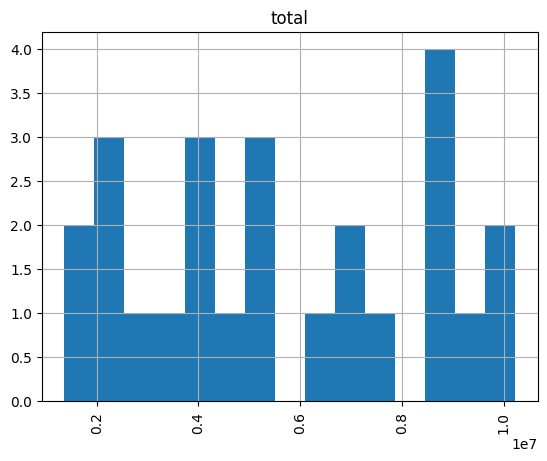

In [18]:
df_total_reads = pd.DataFrame.from_records([(cell, int(df_auto[cell].sum())) for cell in cells], columns=['cell', 'total'])
df_total_reads.hist(column="total", bins=15, xrot=90)

### _Q1d:_ Based on the above plot, we decide to exclude the six cells with a total read count of less than 3,000,000 reads. Which six cells are excluded? [4 points]

You are given the code for the cells that we include.

Set `df_removed_cells` to a DataFrame corresponding to the excluded cells, i.e. those with total read count of less than 3,000,000 reads. Note the type of `df_removed_cells` is not the same as that of `cells_to_keep`, which is a list. Rather, `df_removed_cells` is a DataFrame with two columns `'cell'` representing the name of the cell and `'total'` corresponding with the total read count of that cell.

Specifically, it should be the case that:
    `type(df_removed_cells) == type(df_total_reads)`

In [19]:
# insert code to filter down to cells with less 3,000,000 reads

cells_to_keep = list(df_total_reads[df_total_reads['total'] >= 3000000]['cell'])
df_removed_cells = df_total_reads[df_total_reads['total'] < 3000000]

# YOUR CODE HERE
print("Cells with less than 3,000,000 reads:")
print(df_removed_cells)

# Output the list of cells to keep
print("Cells to keep:")
print(cells_to_keep)

Cells with less than 3,000,000 reads:
         cell    total
1   SRR054598  1784898
3   SRR054594  1361308
7   SRR053676  2036366
19  SRR053679  2021242
20  SRR054604  2473778
22  SRR053607  2784633
Cells to keep:
['SRR089377', 'SRR053605', 'SRR089397', 'SRR054614', 'SRR089402', 'SRR053633', 'SRR053617', 'SRR054608', 'SRR053608', 'SRR054602', 'SRR089401', 'SRR053668', 'SRR054606', 'SRR054613', 'SRR053631', 'SRR054575', 'SRR053611', 'SRR053602', 'SRR054610']


In [20]:
# we retain only cells with >= 300,000 reads
df_auto = df_auto[list(df_auto.columns)[:3] + cells_to_keep]

### _Q1e:_ Complete the below code fragment to identify the mode of each cell and to subsequently normalize the read counts. [4 points]

The key concept is that the majority of bins in a cell are diploid. Since the bins have the same length and under the assumption of uniform genome coverage, we expect the most frequent read count, or the mode, to correspond to the diploid state. We identify the mode by discretizing the read counts for each cell into 20 bins. We then divide the read count for each bin in a cell by the mode.

Make sure to discretize first prior to computing mode. The goal is to have 20 distinct values of reads counts per cell, this allows you to obtain the mode more robustly. To do so, for each cell, you must first identify the largest number of reads. Then, you divide the largest number of reads by 20 (use integer division). Then you need to round down your original number of reads to the nearest discretized number of reads (again possible using integer division).

Please put the result of dividing the read counts in `df_auto` into `df_filter`.

In [24]:
nr_bins = 20

# Use df2 to discretize read count
df2 = df_auto.copy(deep=True)

# Use df_filter to normalize
df_filter = df_auto.copy(deep=True)

for cell in cells_to_keep:
    # insert code to discretize read count (e.g. first integer division by bin_size, then multiply by bin_size)
    # YOUR CODE HERE
    max_reads = df_auto[cell].max()

    bin_size = max_reads // nr_bins

    df2[cell] = (df_auto[cell] // bin_size) * bin_size

df_mode = pd.DataFrame.from_records([(cell, int(df2[cell].mode().iloc[0])) for cell in cells_to_keep],
                                    columns=['cell', 'mode'])

# insert code to divide each read count in df_filter by the mode of the corresponding cell
for cell in cells_to_keep:
    # YOUR CODE HERE
    mode = df_mode[df_mode['cell'] == cell]['mode'].values[0]
    df_filter[cell] = df_filter[cell] / mode

print("Modes of each cell:")
print(df_mode)

print("\nNormalized read counts (df_filter):")
print(df_filter.head())


Modes of each cell:
         cell  mode
0   SRR089377  1989
1   SRR053605   792
2   SRR089397  1738
3   SRR054614  1962
4   SRR089402   981
5   SRR053633  1730
6   SRR053617  1020
7   SRR054608  1308
8   SRR053608   650
9   SRR054602  1115
10  SRR089401   966
11  SRR053668   988
12  SRR054606   548
13  SRR054613  1488
14  SRR053631  1254
15  SRR054575   588
16  SRR053611   990
17  SRR053602   748
18  SRR054610  1680

Normalized read counts (df_filter):
      CHR    START      END  SRR089377  SRR053605  SRR089397  SRR054614  \
bin                                                                       
2    chr1  1833663  2345598   0.888386   1.098485   0.952244   0.826198   
4    chr1  2946627  3452945   1.100553   1.114899   1.197353   0.597859   
6    chr1  4112609  4622985   1.231272   1.155303   1.207135   0.780836   
7    chr1  4622984  5133470   1.047763   1.053030   1.133487   0.804791   
8    chr1  5133469  5640704   1.002514   1.183081   1.288838   0.734455   

     SRR089402  S

## Question 2: Viterbi algorithm [50 points]

In this question we use the Viterbi algorithm to compute a copy number for each bin. The set $Q$ of hidden states corresponds to integer copy numbers. We consider $Q=\{0,\ldots,10\}$. The set $\Sigma$ of emitted symbols are normalized read counts. Since this an infinite set, we use a probability distribution function for each integer copy number to define the emission probabilities. Specifically, for copy number $c \in \{0,\ldots,10\}$ we use a normal distribution with standard deviation $\sigma = 0.1$ centered around mean $\mu_c = c / 2$.

In [26]:
df_norm = pd.read_table("data_filtered_test.csv", sep="\t", index_col=0)

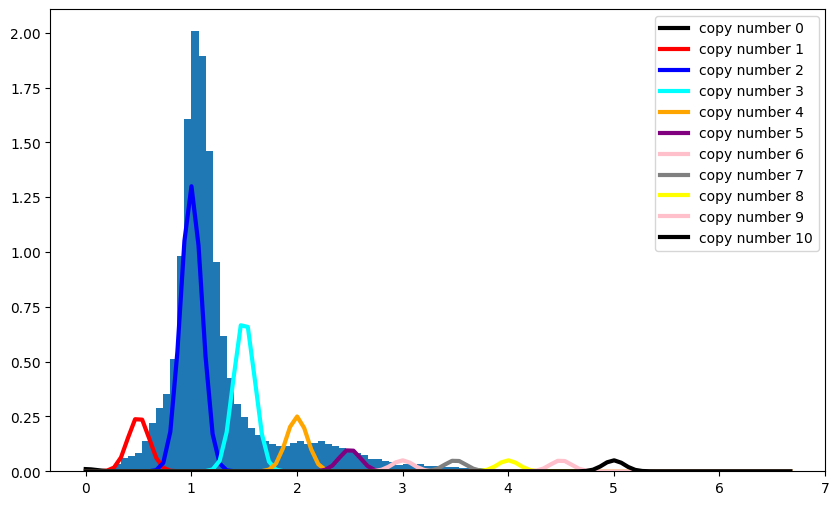

In [27]:
def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

values = [val for sublist in [list(df_norm[cell]) for cell in list(df_norm.columns[3:])] for val in sublist]
count, bins, ignored = plt.hist(values, 100, density=True)

sigma = 0.1

plt.plot(np.array([0,.05,.1,.15,.2]),gauss(np.array([0,.05,.1,.15,.2]), 0, sigma, .01),color='black',lw=3,label='copy number 0')
plt.plot(bins,gauss(bins, 0.5, sigma, .25),color='red',lw=3,label='copy number 1')
plt.plot(bins,gauss(bins, 1, sigma, 1.3),color='blue',lw=3,label='copy number 2')
plt.plot(bins,gauss(bins, 1.5, sigma, .7),color='cyan',lw=3,label='copy number 3')
plt.plot(bins,gauss(bins, 2, sigma, .25),color='orange',lw=3,label='copy number 4')
plt.plot(bins,gauss(bins, 2.5, sigma, .1),color='purple',lw=3,label='copy number 5')
plt.plot(bins,gauss(bins, 3, sigma, .05),color='pink',lw=3,label='copy number 6')
plt.plot(bins,gauss(bins, 3.5, sigma, .05),color='gray',lw=3,label='copy number 7')
plt.plot(bins,gauss(bins, 4, sigma, .05),color='yellow',lw=3,label='copy number 8')
plt.plot(bins,gauss(bins, 4.5, sigma, .05),color='pink',lw=3,label='copy number 9')
plt.plot(bins,gauss(bins, 5, sigma, .05),color='black',lw=3,label='copy number 10')

plt.legend()
plt.gcf().set_size_inches(10, 6)

In [28]:
max_copy_number = 10

def emissionLogProb(copy_number, norm_count):
    sigma = 0.1
    mu = copy_number / 2.

    # Compute Pr(|X_c - norm_count| <= 0.01 | c)
    low = norm.cdf(norm_count - 0.01, mu, sigma)
    up = norm.cdf(norm_count + 0.01, mu, sigma)

    # prevent probability of 0
    prob = max(up - low, 0.0001)

    return np.log(prob)

def transitionLogProb(current_copy_number, next_copy_number):
    stay_prob = 0.99999
    if current_copy_number == next_copy_number:
        return np.log(stay_prob)
    elif 0 <= next_copy_number <= max_copy_number:
        return np.log((1 - stay_prob) / max_copy_number)
    else:
        return np.log(0)

def initialLogProb(copy_number):
    if 0 <= copy_number <= max_copy_number:
        return np.log(1./11)
    else:
        return np.log(0)

### _Q2a:_ Compute the joint log probability of each cell having copy number 2 in all bins. [10 points]

_Hint:_ Make use of the functions `emissionLogProb`, `initialLogProb` and `transitionLogProb` to set the values in the dictionary `joint_log_prob`.

In [29]:
joint_log_prob = {k:0.0 for k in list(df_norm.columns[3:])}
for cell in list(df_norm.columns[3:]):
    log_prob = 0
    for idx, norm_count in df_norm[cell].items():
        # Hint: idx == df_norm.index[0] is the initial item.
        # YOUR CODE HERE
        if idx == df_norm.index[0]:
            log_prob += initialLogProb(copy_number=2) + emissionLogProb(copy_number=2, norm_count=norm_count)
        else:
            log_prob += transitionLogProb(current_copy_number=2, next_copy_number=2) + emissionLogProb(copy_number=2, norm_count=norm_count)
    joint_log_prob[cell] = log_prob

### _Q2b:_ Determine the maximum joint log probability of each cell using the Viterbi algorithm. [20 points]

Complete the function `viterbi`, making use of the functions `emissionLogProb`, `initialLogProb` and `transitionLogProb`.

Then complete the `max_joint_prob` function. The values in the `max_joint_probability` dictionary are filled in after you complete these two functions. This dictionary is autograded.

In [31]:
def viterbi(df_norm, cell):
    # Positions
    bins = sorted(list(df_norm.index))

    # Set of states (copy numbers)
    Q = range(max_copy_number+1)

    # Initialization v[copy_number][bin] = 0
    v = [ { bin : 0 for bin in bins } for c in range(max_copy_number + 1) ]

    for idx, bin in enumerate(bins):
        norm_count = float(df_norm.loc[bin][cell])

        # YOUR CODE HERE
        if idx == 0:
            for c in Q:
                v[c][bin] = initialLogProb(c) + emissionLogProb(c, norm_count)
        else:
            prev_bin = bins[idx - 1]
            for c in Q:  # Current state
                max_prev_prob = float('-inf')
                for c_prev in Q:  # Previous state
                    prob = v[c_prev][prev_bin] + transitionLogProb(c_prev, c)
                    max_prev_prob = max(max_prev_prob, prob)
                v[c][bin] = max_prev_prob + emissionLogProb(c, norm_count)


    return v

def max_joint_prob(df_norm, v):
    # Positions
    bins = sorted(list(df_norm.index))

    # Set of states (copy numbers)
    Q = range(max_copy_number+1)
    last_bin = bins[-1]
    max_joint_probability = float('-inf')

    # YOUR CODE HERE
    for c in Q:  # Find maximum probability in the last bin across all states
        max_joint_probability = max(max_joint_probability, v[c][last_bin])

    return max_joint_probability

max_joint_probability = {}
V = {}
for cell in list(df_norm.columns[3:]):
    V[cell] = viterbi(df_norm, cell)
    max_joint_probability[cell] = max_joint_prob(df_norm, V[cell])

### _Q2c:_ Compute the most likely copy number profile for each cell. [10 points]

**Note**: You should break ties by the order of the hidden states in $Q$.

_Hint:_ Hint perform a backtrace or extend the above `viterbi` function to maintain backpointers.

In [32]:
def viterbi_bt(df_norm, cell):
    # Positions
    bins = sorted(list(df_norm.index))

    # Set of states (copy numbers)
    Q = range(max_copy_number+1)

    # Initialization v[copy_number][bin] = 0
    v = [ { bin : 0 for bin in bins } for c in range(max_copy_number + 1) ]
    bt = [ { bin : None for bin in bins } for c in range(max_copy_number + 1) ]

    for idx, bin in enumerate(bins):
        norm_count = float(df_norm.loc[bin][cell])

        # YOUR CODE HERE
        if idx == 0:
            for c in Q:
                v[c][bin] = initialLogProb(c) + emissionLogProb(c, norm_count)
        else:
            prev_bin = bins[idx - 1]
            for c in Q:
                max_prev_prob = float('-inf')
                max_prev_state = None
                for c_prev in Q:
                    prob = v[c_prev][prev_bin] + transitionLogProb(c_prev, c)
                    if prob > max_prev_prob:
                        max_prev_prob = prob
                        max_prev_state = c_prev
                v[c][bin] = max_prev_prob + emissionLogProb(c, norm_count)
                bt[c][bin] = max_prev_state

    return v, bt

bins = sorted(list(df_norm.index))
Q = range(max_copy_number+1)

V = {}
BT = {}
C = {}
max_joint_probability = {}
for cell in list(df_norm.columns[3:]):
    V[cell], BT[cell] = viterbi_bt(df_norm, cell)
    C[cell] = {}

    max_prob = max_joint_prob(df_norm, V[cell])
    final_c = None
    final_bin = bins[-1]
    for c in Q:
        if V[cell][c][final_bin] == max_prob:
            final_c = c

    C[cell][final_bin] = final_c

    for idx in range(len(bins)-2, -1, -1):
        bin = bins[idx]
        next_bin = bins[idx + 1]
        next_bin_c = C[cell][next_bin]
        C[cell][bin] = BT[cell][next_bin_c][next_bin]

    max_joint_probability[cell] = max_prob
    print(cell, "--", "max prob:", max_prob)

SRR089377 -- max prob: -15135.07096710289
SRR053605 -- max prob: -15545.061291453789
SRR089397 -- max prob: -15308.765158063214
SRR054614 -- max prob: -21459.85971466328
SRR089402 -- max prob: -26926.698867515544
SRR053633 -- max prob: -17806.476991178395
SRR053617 -- max prob: -16345.74922800195
SRR054608 -- max prob: -21893.73594081532
SRR053608 -- max prob: -16321.148713951978
SRR054602 -- max prob: -22052.950647001708
SRR089401 -- max prob: -25818.24091555924
SRR053668 -- max prob: -17933.50037237371
SRR054606 -- max prob: -25598.446215727326
SRR054613 -- max prob: -21730.2333361158
SRR053631 -- max prob: -21461.508174337996
SRR054575 -- max prob: -26713.527991256262
SRR053611 -- max prob: -15312.762620958683
SRR053602 -- max prob: -18024.067571223906
SRR054610 -- max prob: -21836.19569778152


### _Q2d:_ How many cells are normal (i.e. have copy number 2 for each bin)? [10 points]

Use `visualizeCopyNumbers(C, bins)` to set the value of `num_normal_cells`.


In [33]:
bins = sorted(list(df_norm.index))

In [34]:
def visualizeCopyNumbers(C, bins):
    nrRows = 5
    nrCols = 4
    for idx, cell in enumerate(C):
        ax = plt.subplot(nrRows, nrCols, idx+1)
        plt.step(list(range(len(bins))), list(C[cell].values()))
        ax.set_title(cell)
        ax.set_ylim((0, 10))
        ax.set_xlabel("bin")
        ax.set_ylabel("copy number")
    plt.gcf().set_size_inches(30, 20)
    plt.tight_layout()
    plt.savefig("viterbi.pdf")

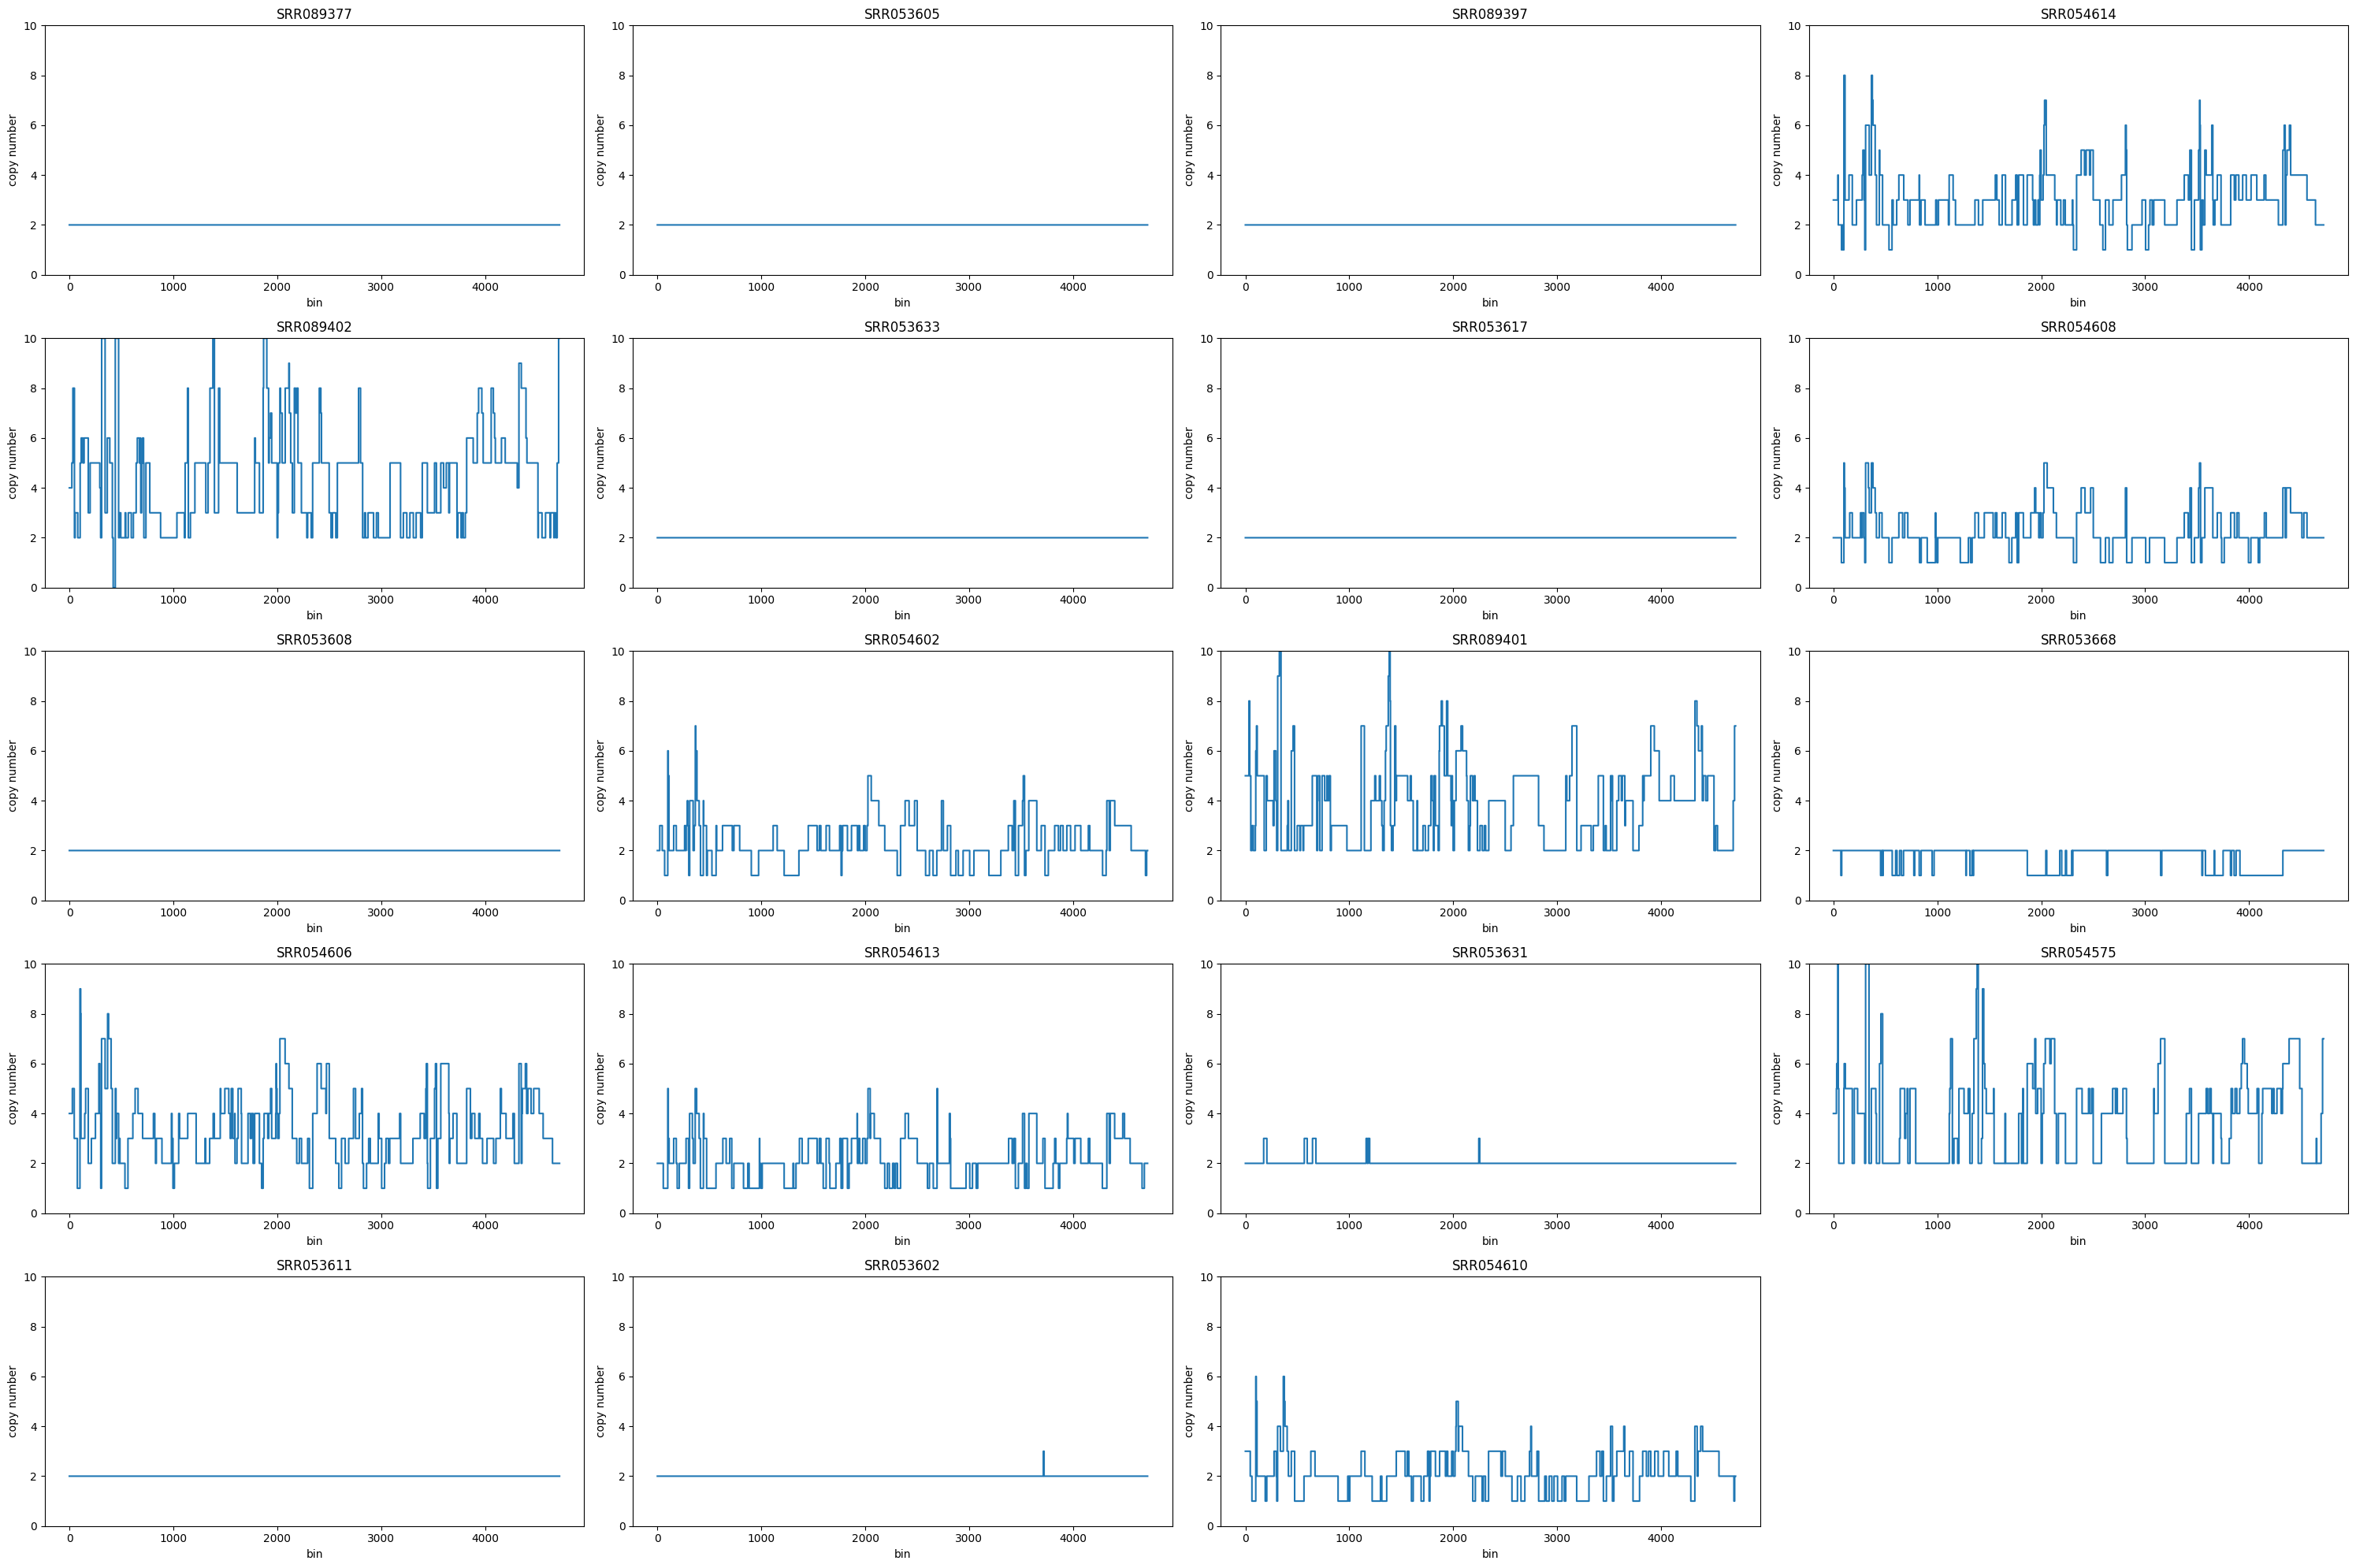

In [35]:
visualizeCopyNumbers(C, bins)
num_normal_cells = sum(all(C[cell][bin] == 2 for bin in bins) for cell in C)


### _Q2e -- Bonus:_ Extend the plotting function to delineate chromosomes using vertical lines.  [5 points]

- Do not forget to update x-axis labels to show chromosomes.
- The output of 2e should be similar to 2d except with vertical delineations.
- Generate the plot in the cell below.

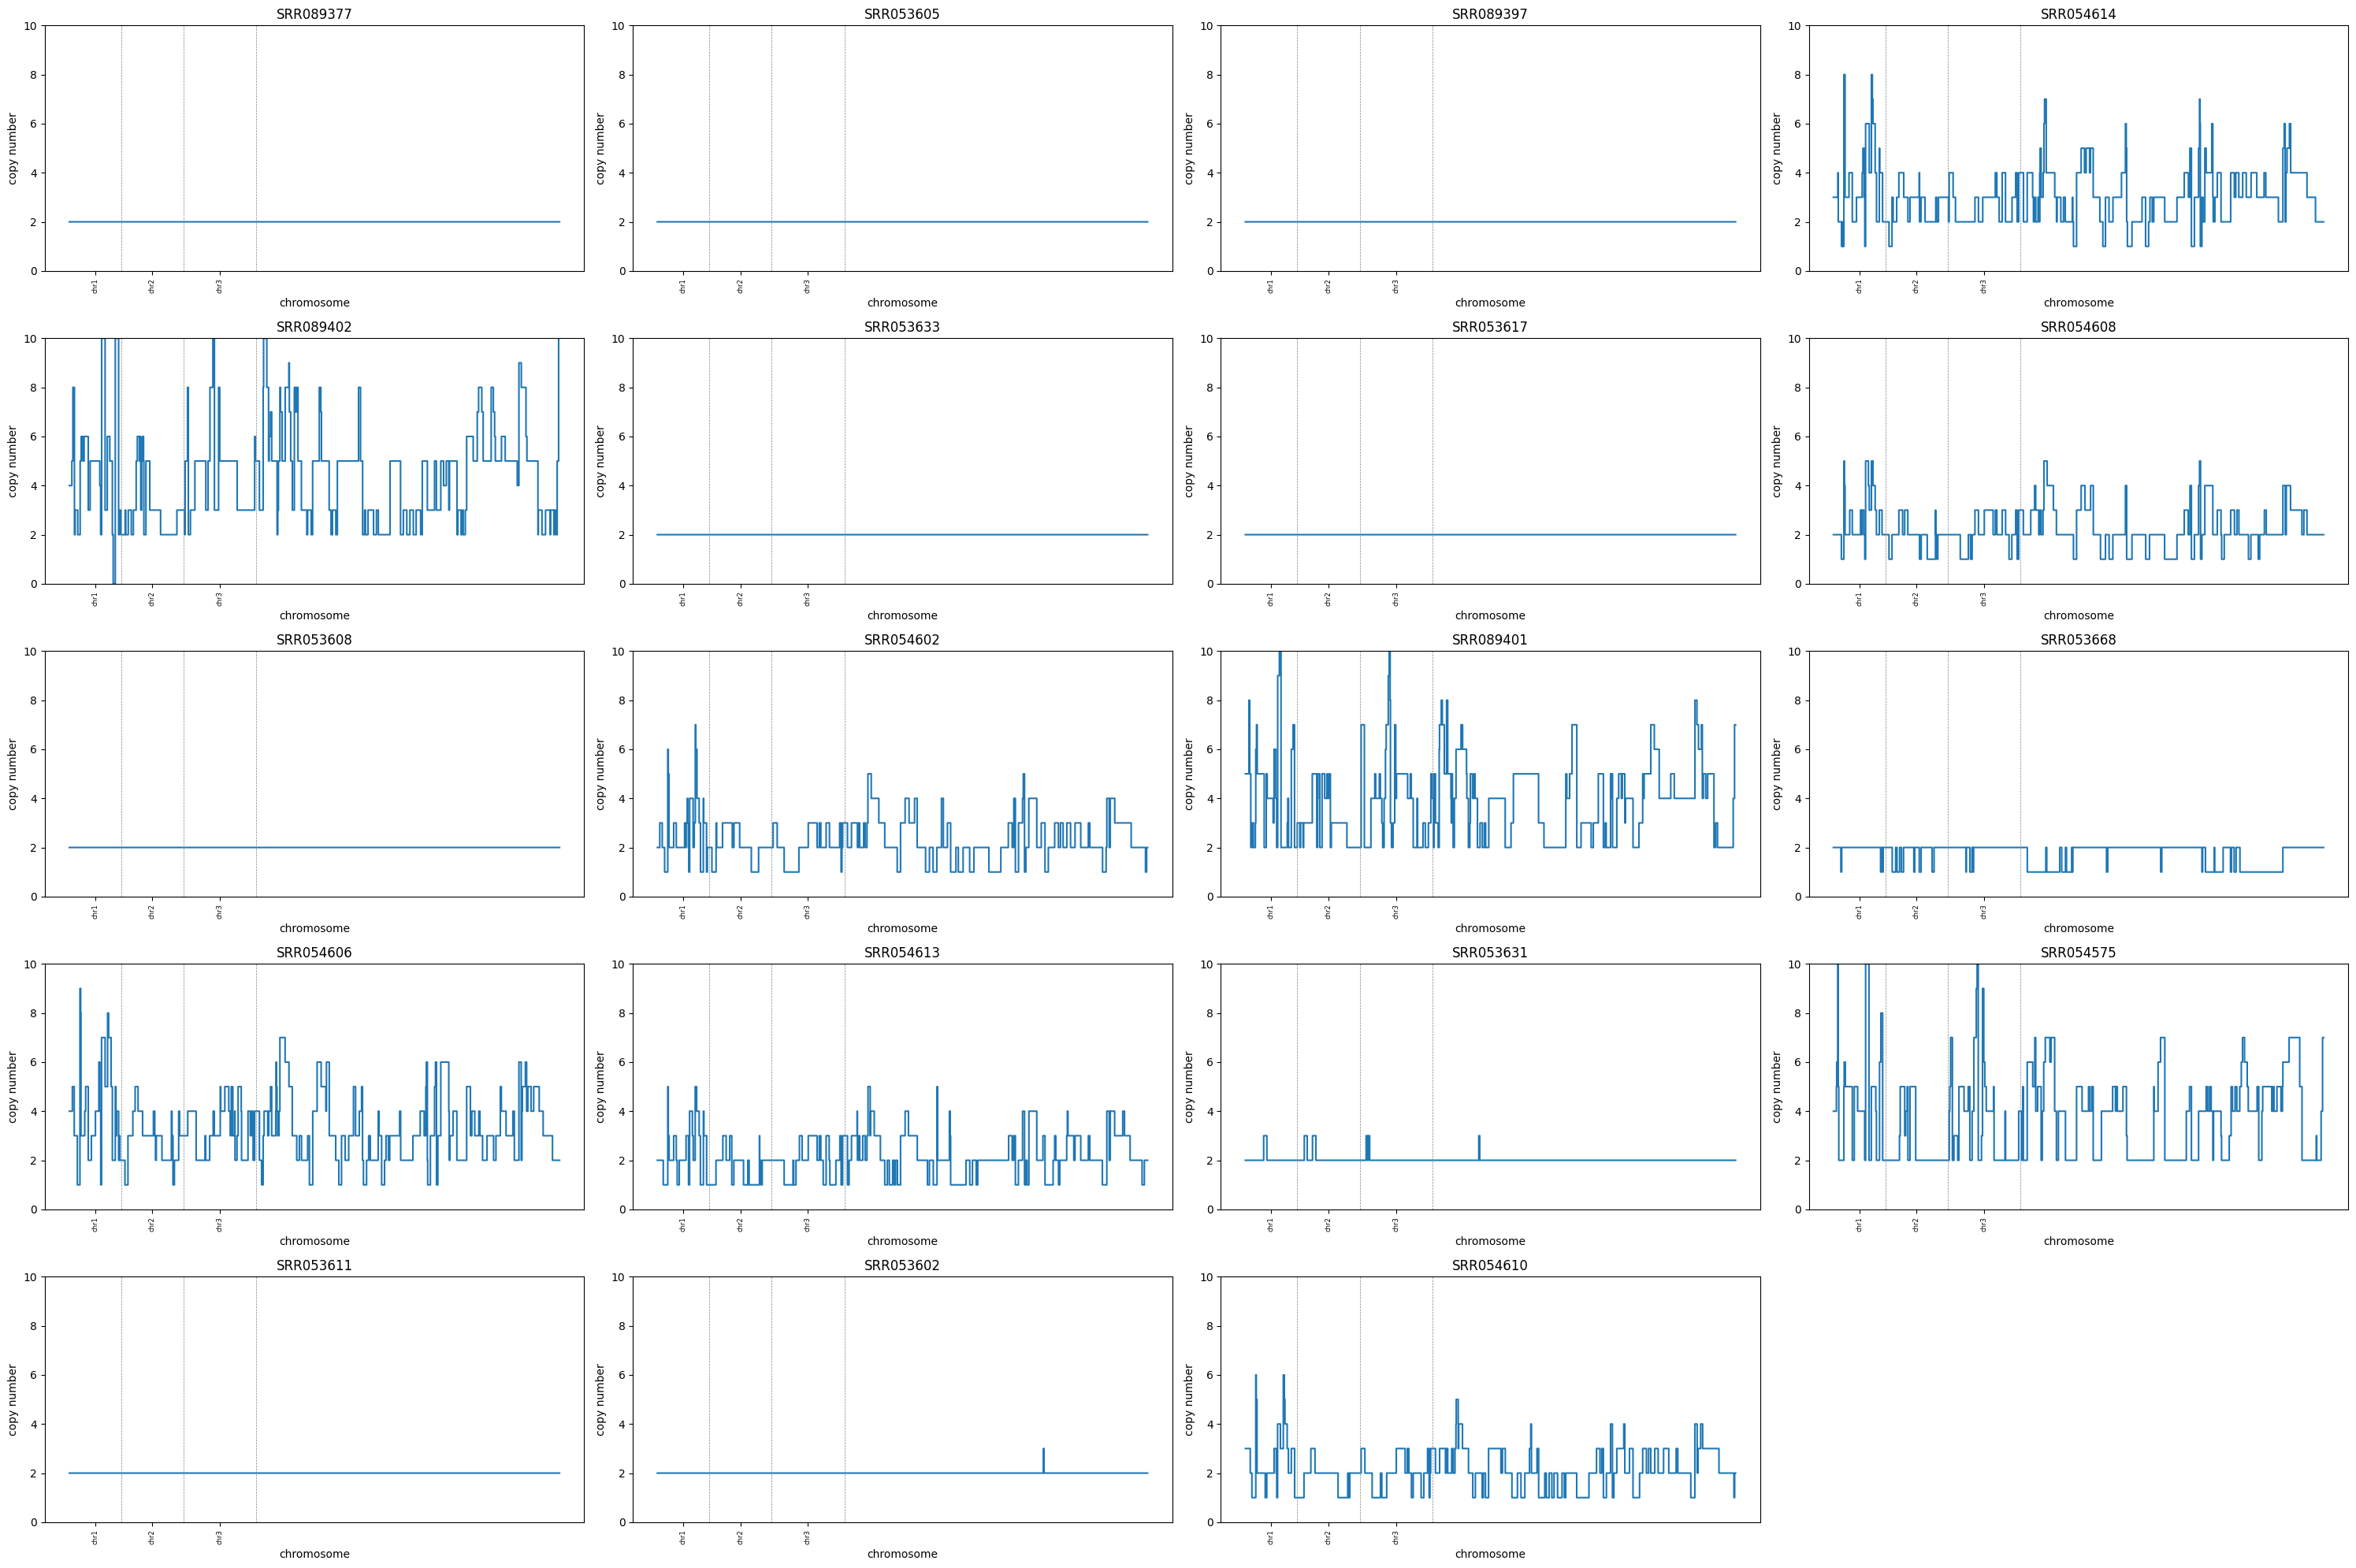

In [37]:
# YOUR CODE HERE
def visualizeCopyNumbersChromosomes(C, bins, chr_labels):

    nrRows = 5
    nrCols = 4
    unique_chromosomes = sorted(set(chr_labels))

    chr_positions = {chr_: [] for chr_ in unique_chromosomes}
    for idx, chr_ in enumerate(chr_labels):
        chr_positions[chr_].append(idx)

    for idx, cell in enumerate(C):
        ax = plt.subplot(nrRows, nrCols, idx+1)
        plt.step(list(range(len(bins))), list(C[cell].values()))

        for chr_ in unique_chromosomes:
            if chr_positions[chr_]:
                boundary = max(chr_positions[chr_]) + 0.5
                plt.axvline(boundary, color='gray', linestyle='--', linewidth=0.5)

        ax.set_xticks([min(chr_positions[chr_]) + (max(chr_positions[chr_]) - min(chr_positions[chr_])) // 2 for chr_ in unique_chromosomes])
        ax.set_xticklabels(unique_chromosomes, rotation=90, fontsize=6)

        ax.set_title(cell)
        ax.set_ylim((0, 10))
        ax.set_xlabel("chromosome")
        ax.set_ylabel("copy number")

    plt.gcf().set_size_inches(30, 20)
    plt.tight_layout()
    plt.savefig("viterbi_with_chromosomes.pdf")

chr_labels = ["chr1"] * 500 + ["chr2"] * 600 + ["chr3"] * 700

visualizeCopyNumbersChromosomes(C, bins, chr_labels)


## Question 3: Forward algorithm [10 points]

### _Q3a:_ Compute the marginal log probability of the observations using the forward algorithm. [10 points]

Complete the `forward` and `marginal_log_prob` functions defined below.

Be aware that recurrence of the forward algorithm includes a summation, but we are operating in log space.

You may find `logsumexp` in scipy useful, and you can find more details [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.logsumexp.html).

In [38]:
def forward(df_norm, cell):
    # Positions
    bins = sorted(list(df_norm.index))

    # Set of states (copy numbers)
    Q = range(max_copy_number+1)

    f = [ { bin : 0 for bin in bins } for c in range(max_copy_number + 1) ]

    for idx, bin in enumerate(bins):
        norm_count = float(df_norm.loc[bin][cell])

        # YOUR CODE HERE
        if idx == 0:
            for c in Q:
                f[c][bin] = initialLogProb(c) + emissionLogProb(c, norm_count)
        else:
            prev_bin = bins[idx - 1]
            for c in Q:
                transition_probs = [f[c_prev][prev_bin] + transitionLogProb(c_prev, c) for c_prev in Q]
                f[c][bin] = logsumexp(transition_probs) + emissionLogProb(c, norm_count)

    return f

def marginal_log_prob(df_norm, f):
    # Positions
    bins = sorted(list(df_norm.index))

    # Set of states (copy numbers)
    Q = range(max_copy_number+1)
    last_bin = bins[-1]

    marginal_log_probability = logsumexp([f[c][last_bin] for c in Q])
    # YOUR CODE HERE
    return marginal_log_probability

F = {}
marginal_log_probability = {}
for cell in list(df_norm.columns[3:]):
    F[cell] = forward(df_norm, cell)
    marginal_log_probability[cell] = marginal_log_prob(df_norm, F[cell])
    print(cell, "--", "marginal log prob:", marginal_log_probability[cell])

SRR089377 -- marginal log prob: -15135.070967014828
SRR053605 -- marginal log prob: -15544.611184867948
SRR089397 -- marginal log prob: -15308.765157886717
SRR054614 -- marginal log prob: -21413.96213411058
SRR089402 -- marginal log prob: -26856.478250887812
SRR053633 -- marginal log prob: -17806.46758695682
SRR053617 -- marginal log prob: -16345.748979990469
SRR054608 -- marginal log prob: -21866.800713403914
SRR053608 -- marginal log prob: -16321.148713459987
SRR054602 -- marginal log prob: -22021.28507855936
SRR089401 -- marginal log prob: -25755.43253433875
SRR053668 -- marginal log prob: -17925.96693300913
SRR054606 -- marginal log prob: -25538.887652678783
SRR054613 -- marginal log prob: -21695.728236030627
SRR053631 -- marginal log prob: -21456.65905730224
SRR054575 -- marginal log prob: -26652.330590104862
SRR053611 -- marginal log prob: -15312.762620818836
SRR053602 -- marginal log prob: -18023.959457052213
SRR054610 -- marginal log prob: -21801.796193855364


## Question 4: Hierarchical clustering [20 points]
The Python package `scipy` implements hierarchical clustering. We will use this method to perform single linkage cluster with the Manhattan (also known as cityblock) distance metric.

In [40]:
C_labels = list(C.keys())
C_values = [list(C[cell].values()) for cell in C_labels]

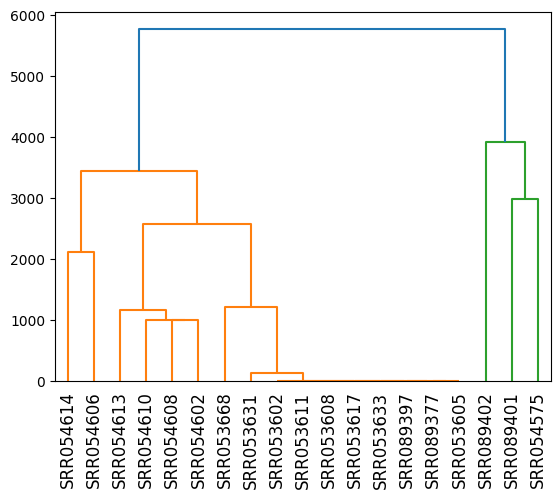

In [41]:
Z = hierarchy.linkage(C_values, 'single', 'cityblock')
plt.figure()
dn = hierarchy.dendrogram(Z, labels=C_labels, leaf_rotation=90)
plt.show()

The goal of this question is to reimplement this algorithm. We start by computing the initial distance matrix.

### _Q4a:_ Compute the initial distance matrix using Manhattan distance. [10 points]

In [39]:
def manhattan(C, cell_1, cell_2, bins):
    value = 0
    # YOUR CODE HERE
    for bin in bins:
        value += abs(C[cell_1][bin] - C[cell_2][bin])
    return value


bins = sorted(list(df_norm.index))
dist = {}
for cell_1 in C.keys():
    dist[cell_1] = {}
    for cell_2 in C.keys():
        dist[cell_1][cell_2] = manhattan(C, cell_1, cell_2, bins)

### _Q4b:_ Implement single linkage clustering. [10 points]
_Hint:_ The documentation for the required output format is described here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage

**NOTE**: There may be more than one pair of (c1, c2) that gives you the minimum dist. You should break ties in the dictionary order.

In [46]:
def cluster(distances):
    distances = copy.deepcopy(distances)
    clusters = set(distances.keys())
    n = len(clusters)
    cluster2idx = { cell : idx for idx, cell in enumerate(clusters) }
    idx2cluster = [ cell for cell in clusters ]
    Z = np.empty((0, 4), float)
    membership = [ set([cluster2idx[cell]]) for cell in clusters ]
    while len(clusters) > 1:
        # TODO: identify pair (c1, c2) with minimum distance dist
        dist, c1, c2 = float('inf'), None, None
        # YOUR CODE HERE
        for cell_1 in distances:
            for cell_2 in distances[cell_1]:
                if cell_1 != cell_2 and distances[cell_1][cell_2] < dist:
                    dist = distances[cell_1][cell_2]
                    c1, c2 = cell_1, cell_2
                elif cell_1 != cell_2 and distances[cell_1][cell_2] == dist:
                    if c1 is None or (cell_1 < c1 or (cell_1 == c1 and cell_2 < c2)):
                        c1, c2 = cell_1, cell_2


        idx_c1 = cluster2idx[c1]
        idx_c2 = cluster2idx[c2]
        new_cluster = str(n + len(Z))
        new_cluster_idx = len(idx2cluster)

        membership.append( membership[idx_c1] | membership[idx_c2])
        Z = np.append(Z,
                      np.array([[cluster2idx[c1], cluster2idx[c2], dist, len(membership[new_cluster_idx])]]),
                      axis=0)

        # YOUR CODE HERE
        for other in clusters:
            if other != c1 and other != c2:
                new_distance = min(distances[c1][other], distances[c2][other])
                distances[c1][other] = new_distance
                distances[other][c1] = new_distance
        distances[new_cluster] = {}
        for other in clusters:
            if other != c1 and other != c2:
                distances[new_cluster][other] = distances[c1][other]
                distances[other][new_cluster] = distances[c1][other]

        clusters.add(new_cluster)
        cluster2idx[new_cluster] = len(idx2cluster)
        idx2cluster.append(new_cluster)

        clusters.remove(c1)
        clusters.remove(c2)
        del distances[c1]
        del distances[c2]
        for other in distances:
            distances[other].pop(c1, None)
            distances[other].pop(c2, None)

    return Z, idx2cluster[:n]

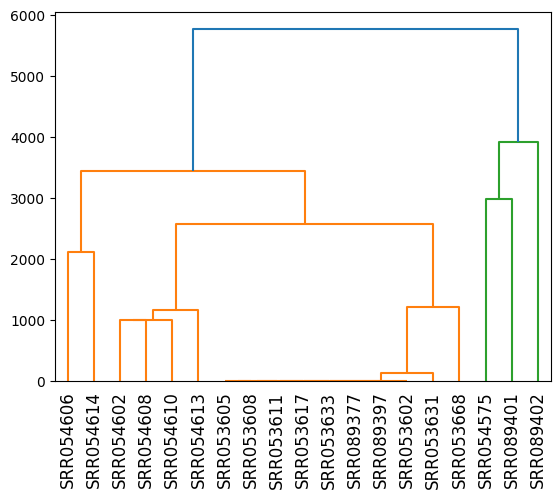

In [47]:
Z, labels = cluster(dist)
plt.figure()
dn = hierarchy.dendrogram(Z, labels=labels, leaf_rotation=90)
plt.show()

### _Q4c :_ Implement complete linkage clustering. [5 points]
_Hint:_ The documentation for the required output format is described here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage. Your plot should be identical to the below scipy plot.

**NOTE**: There may be more than one pair of (c1, c2) that gives you the minimum dist. You should break ties in the dictionary order.

In [ ]:
Z = hierarchy.linkage(C_values, 'complete', 'cityblock')
plt.figure()
dn = hierarchy.dendrogram(Z, labels=C_labels, leaf_rotation=90)
plt.show()

In [55]:
def complete_cluster(distances):
    distances = copy.deepcopy(distances)
    clusters = set(distances.keys())
    n = len(clusters)
    cluster2idx = { cell : idx for idx, cell in enumerate(clusters) }
    idx2cluster = [ cell for cell in clusters ]
    Z = np.empty((0, 4), float)
    membership = [ set([cluster2idx[cell]]) for cell in clusters ]
    while len(clusters) > 1:
        # TODO: identify pair (c1, c2) with minimum distance dist
        dist, c1, c2 = float('inf'), None, None
        # YOUR CODE HERE
        for cell_1 in distances:
            for cell_2 in distances[cell_1]:
                if cell_1 != cell_2 and distances[cell_1][cell_2] < dist:
                    dist = distances[cell_1][cell_2]
                    c1, c2 = cell_1, cell_2
                elif cell_1 != cell_2 and distances[cell_1][cell_2] == dist:
                    if c1 is None or (cell_1 < c1 or (cell_1 == c1 and cell_2 < c2)):
                        c1, c2 = cell_1, cell_2

        idx_c1 = cluster2idx[c1]
        idx_c2 = cluster2idx[c2]
        new_cluster = str(n + len(Z))
        new_cluster_idx = len(idx2cluster)

        membership.append( membership[idx_c1] | membership[idx_c2])
        Z = np.append(Z,
                      np.array([[cluster2idx[c1], cluster2idx[c2], dist, len(membership[new_cluster_idx])]]),
                      axis=0)

        # YOUR CODE HERE
        distances[new_cluster] = {}
        for other in clusters:
            if other != c1 and other != c2:
                new_distance = max(distances[c1][other], distances[c2][other])
                distances[new_cluster][other] = new_distance
                distances[other][new_cluster] = new_distance


        clusters.add(new_cluster)
        cluster2idx[new_cluster] = len(idx2cluster)
        idx2cluster.append(new_cluster)

        clusters.remove(c1)
        clusters.remove(c2)
        del distances[c1]
        del distances[c2]
        for other in distances:
            distances[other].pop(c1, None)
            distances[other].pop(c2, None)

    return Z, idx2cluster[:n]

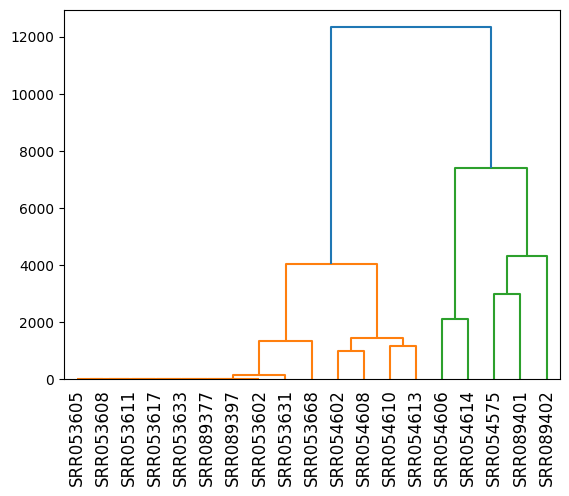

In [56]:
Z, labels = complete_cluster(dist)
plt.figure()
dn = hierarchy.dendrogram(Z, labels=labels, leaf_rotation=90)
plt.show()